In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

plt.style.use('rossidata')

In [194]:
data=pd.read_csv('data/megaframe.csv')
data['Time of Death'][data['Time of Death']==0]=np.nan
data['Time of Death'][data['Time of Death']==-1]=64
data=data[~np.isnan(data['Time of Death'])]
data['alive']=np.nan

In [73]:
### Killing curve plots

plt.close('all')
fig,ax=plt.subplots()
fig2,ax2=plt.subplots()
strains=data['Strain'].unique()

colorz = cm.tab20(np.linspace(0, 1, len(strains)))
recs=[]

for z,strain in enumerate(strains):
    sliceo=data[data['Strain']==strain]
    maxval=len(sliceo)
    traj=[]
    xvect=np.linspace(0,60*5,61)
    for t in range(61):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)

    ax.plot(xvect,traj,label=strain,color=colorz[z])
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colorz[z]))

    
    ind=next(x[0] for x in enumerate(traj) if x[1] < .6)
    start=np.mean(sliceo['Fluor1 mean'])
    end=np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start
    ax2.bar(5-z,np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start-1,color=colorz[z])

#     ax2.scatter(1,5-z,color='black',s=100)
#     ax2.scatter(np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start,5-z,color=colorz[z],s=200)
#     ax2.annotate('',xy=(end,5-z),
#             xytext=(1,5-z), va='center', multialignment='right',
#             arrowprops={'arrowstyle': '->', 'lw': 4, 'ec': 'grey','alpha': 0.25})
ax.legend(recs, strains, title='Reporter', loc=1,ncol=2,bbox_to_anchor=(1.6, 1))
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('% Cells alive')
fig.savefig('figures/killing_curves.png',dpi=300)
#fig2

In [216]:
### arrow plots
### Killing curve plots

plt.close('all')
fig2,ax2=plt.subplots()
strains=data['Strain'].unique()

colorz = cm.tab20(np.linspace(0, 1, len(strains)))
recs=[]
for z,strain in enumerate(strains):
    sliceo=data[data['Strain']==strain]
    maxval=len(sliceo)
    traj=[]
    xvect=np.linspace(0,60*5,61)
    for t in range(61):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)

    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colorz[z]))

    ind=next(x[0] for x in enumerate(traj) if x[1] < .5)

    start=np.mean(sliceo['Fluor1 mean'])
    end=np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start
#     ax2.bar(5-z,np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start-1,color=colorz[z])

    ax2.scatter(1,5-z,color='black',s=100)
    ax2.scatter(np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start,5-z,color=colorz[z],s=200)
    ax2.annotate('',xy=(end,5-z),
    xytext=(1,5-z), va='center', multialignment='right',
    arrowprops={'arrowstyle': '->', 'lw': 4, 'ec': 'grey','alpha': 0.25})
#fig.savefig('figures/killing_curves.png',dpi=300)
fig2.savefig('figures/arrow_plot.png',dpi=300)

StopIteration: 

In [215]:
data[data['Strain']==strain]['alive']=list(data[data['Strain']==strain]['Time of Death']>=ind)


In [223]:
### logistic regression plots
plt.close('all')    
def model(x):
    return 1 / (1 + np.exp(-x))

def information_calculator(px):
    return 1-(-px*np.log2(px)-(1-px)*np.log2(1-px))


fig,ax=plt.subplots()
barfig,barax=plt.subplots()
strains=data['Strain'].unique()
colorz = cm.tab20(np.linspace(0, 1, len(strains)))
values=[]
for z,strain in enumerate(strains):
    sliceo=data[data['Strain']==strain]
    maxval=len(sliceo[~np.isnan(sliceo['Time of Death'])])
    traj=[]

    for t in range(61):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)


    try:
        ind=next(x[0] for x in enumerate(traj) if x[1] < .5)
        data[data['Strain']==strain]['alive']=list(data[data['Strain']==strain]['Time of Death']>=ind)

    except:
        print(strain+' cells do not die enough')
        ind=61
        data[data['Strain']==strain]['alive']=list(data[data['Strain']==strain]['Time of Death']>=ind)

    
    clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs')


    dead=sliceo[sliceo['Time of Death']<=ind]['Fluor1 mean'].values
    alive=sliceo[sliceo['Time of Death']>ind]['Fluor1 mean'].values

    data_tot=np.concatenate((dead, alive))
    clf.fit(data_tot.reshape(-1, 1) , np.concatenate((np.zeros(len(dead)), np.ones(len(alive)))).reshape(-1, 1) )
    X_test=np.linspace(min(data_tot),max(data_tot),1000)

    loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot((X_test-min(data_tot))/(max(data_tot)-min(data_tot)), loss, color=colorz[z])
    values.append(np.mean(information_calculator(loss)))

d = {'values': values, 'strains': strains}
df = pd.DataFrame(data=d)
df.sort_values('values', ascending=True).plot.bar(x='strains',ax=barax,color='#e684ae')
barax.set_ylabel('Information (bits)')


barfig.savefig('figures/information_bar.png',dpi=300)


ax.legend(recs, strains, title='Reporter', loc=1,ncol=2,bbox_to_anchor=(1.6, 1))

fig.savefig('figures/logistic.png',dpi=300)


rpsT cells do not die enough
micF cells do not die enough


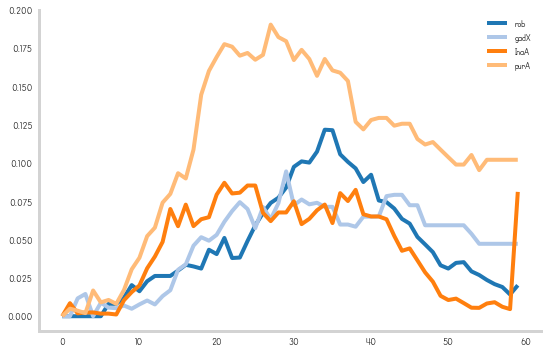

In [159]:
plt.close('all')    
def model(x):
    return 1 / (1 + np.exp(-x))

def information_calculator(px):
    vals=1-(-px*np.log2(px)-(1-px)*np.log2(1-px))
    vals[np.isnan(vals)]=1
    return vals


fig,ax=plt.subplots()
barfig,barax=plt.subplots()
strains=data['Strain'].unique()
colorz = cm.tab20(np.linspace(0, 1, len(strains)))
values=[]
strainz=['rob','gadX','InaA','purA']
for z,strain in enumerate(strainz):
    sliceo=data[data['Strain']==strain]
    sliceo=sliceo[~np.isnan(sliceo['Time of Death'])]
    maxval=len(sliceo)
    traj=[]

    for t in range(60):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)
    InitialAu=sliceo['Fluor1 mean']
    Deathtime=sliceo['Time of Death']

    d = {'InitialAu': InitialAu, 'DeathTime': Deathtime}
    df = pd.DataFrame(data=d)

    df=df.dropna()
    s={'fluor':df['InitialAu'],'death':df['DeathTime']}
    sd=pd.DataFrame(s)
    sd=sd.sort_values(by='fluor')
    n_splits=4
    rez=np.array_split(sd, n_splits)
    column_num=61
    bins=np.arange(column_num)
    grid=np.zeros((n_splits,column_num-1))
    labels=np.zeros((n_splits,column_num-1))
    mins=[]

    for x in range(n_splits):
        grid[x,:]=np.cumsum(np.histogram(rez[x].death, bins=bins)[0]/len(rez[x].death))

    ax.plot(np.nanmean(information_calculator(grid),0)-information_calculator(np.asarray(traj)),color=colorz[z],label=strain)

ax.legend()

fig




In [153]:
strains


array(['dnaQ', 'Fis', 'tonB', 'CodB', 'marRAB', 'gadX', 'crp', 'ompF',
       'sigma70', 'SoxS', 'purA', 'hdeA', 'rob', 'rrnbp1', 'acrAB', 'InaA',
       'rpsT', 'micF'], dtype=object)

In [3]:

#### Distribution animations
plt.close('all')
fig,ax=plt.subplots()
sliceo=data[data['Strain']=='rob']

traj=[]
xvect=np.linspace(0,60*5,61)
for t in range(61):
    traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)

ind=next(x[0] for x in enumerate(traj) if x[1] < 0.1)
        
datum=sliceo['Fluor1 mean']
datum2=sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind]
# probs, bons = np.histogram(sliceo['Fluor1 mean'], normed='True', bins=bins)
# ax.plot(bons[1:], np.cumsum(probs / np.sum(probs)),  drawstyle='steps-pre')
# probs, bons = np.histogram(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind], normed='True', bins=bins)
# ax.plot(bons[1:], np.cumsum(probs / np.sum|(probs)),  drawstyle='steps-pre')
# fig


density = gaussian_kde(datum)
xs = np.linspace(500,16000,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs,density(xs))

density = gaussian_kde(datum2)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs,density(xs))

ax.set_xscale('log')
fig

NameError: name 'maxval' is not defined

In [62]:
### animation of distribution
plt.close('all')
fig_animate,ax=plt.subplots()

lines=[]
sliceos=[data[data['Strain']=='rob'],data[data['Strain']=='purA']]
colors=['#e684ae','teal']
for n,l in enumerate(sliceos):
    lines.append(ax.plot([],[],color=colors[n]))
xs = np.linspace(500,16000,200)
ax.set_xlim([500,16000])
ax.set_xscale('log')
ax.set_ylim([0,.0006])
def animate(z):
    for j,sliceo in enumerate(sliceos):
        density = gaussian_kde(sliceo['Fluor1 mean'][sliceo['Time of Death']>=z])
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ax.plot(xs,density(xs),color='grey',alpha=0.05)

        lines[j][0].set_data(xs,density(xs))

    return lines

anim3 = animation.FuncAnimation(fig_animate, animate,frames=61,  blit=False)
plt.tight_layout()
anim3.save('evolution.mp4', writer='ffmpeg',bitrate=1800)
#HTML(anim3.to_html5_video())

In [94]:
#heatmaps

#dataload

for strain in strains:
    plt.close('all')
    sliceo=data[data['Strain']==strain]



    InitialAu=sliceo['Fluor1 mean']
    Deathtime=sliceo['Time of Death']

    d = {'InitialAu': InitialAu, 'DeathTime': Deathtime}
    df = pd.DataFrame(data=d)
    df['DeathTime'][df['DeathTime']==-1]=62
    df['DeathTime'][df['DeathTime']==0]=np.nan

    fig,ax=plt.subplots()
    df=df.dropna()
    s={'fluor':df['InitialAu'],'death':5*df['DeathTime']}
    sd=pd.DataFrame(s)
    sd=sd.sort_values(by='fluor')
    n_splits=10
    rez=np.array_split(sd, n_splits)
    column_num=10
    bins=np.linspace(0,300,column_num)-10
    grid=np.zeros((n_splits,column_num-1))
    labels=np.zeros((n_splits,column_num-1))
    mins=[]
    
    for x in range(n_splits):
        mino,maxo=min(rez[x].fluor),max(rez[x].fluor)
        grid[x,:]=np.cumsum(np.histogram(rez[x].death, bins=bins)[0]/len(rez[x].death))
        labels[x,:]=np.histogram(rez[x].death, bins=bins)[0]
        mins.append(str((x+1)*10)+'%')

    sns.heatmap(np.flipud(grid)*100,yticklabels=np.flipud(mins),xticklabels=[int(u) for u in bins[1:]],cmap="rainbow",vmin=0, vmax=100,cbar_kws={'label': '% chance of death'})
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Fluorescence at t0 (A.U)')
    ax.set_title(strain)
    fig.savefig('figures/'+strain+'_heatmap.png',dpi=300)

In [89]:
n_splits

10

In [226]:
### violin plots
fig,ax=plt.subplots(figsize=(20,3))
sns.violinplot(x='strain',y='Fluor1 mean',d=data,axis=ax,  palette="muted", split=True)
fig

ValueError: Could not interpret input 'strain'

In [227]:
data

,Unnamed: 0,Cell ID,Region num birth,Region num death,Cell birth time,Cell death time,Cell age,Old pole age,Error frame,stat0,...,Long axis/Short axis birth,Long axis/Short axis death,Neck width,Maximum width,Cell dist to edge,Growth Rate,Time of Death,Strain,Fluor3 mean,alive
0,0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,...,5.252623,5.252623,5.140289,6.800495,1.0,NaN,10.0,dnaQ,NaN,NaN
1,1,2.0,2.0,2.0,1.0,1.0,0.0,NaN,NaN,0.0,...,4.778338,4.778338,6.069056,7.074749,1.0,NaN,40.0,dnaQ,NaN,NaN
2,2,3.0,3.0,3.0,1.0,1.0,0.0,NaN,NaN,0.0,...,3.193998,3.193998,6.261745,7.101432,1.0,NaN,64.0,dnaQ,NaN,NaN
3,3,4.0,4.0,4.0,1.0,1.0,0.0,NaN,NaN,0.0,...,3.856252,3.856252,6.034089,7.041665,1.0,NaN,17.0,dnaQ,NaN,NaN
4,4,5.0,5.0,5.0,1.0,1.0,0.0,NaN,NaN,0.0,...,5.084156,5.084156,5.996672,7.013226,1.0,NaN,16.0,dnaQ,NaN,NaN
5,5,6.0,6.0,6.0,1.0,1.0,0.0,NaN,NaN,0.0,...,4.446054,4.446054,6.072800,7.096646,1.0,NaN,24.0,dnaQ,NaN,NaN
6,6,7.0,7.0,7.0,1.0,1.0,0.0,NaN,NaN,0.0,...,4.277396,4.277396,6.018657,7.561132,1.0,NaN,22.0,dnaQ,NaN,NaN
7,7,8.0,8.0,8.0,1.0,1.0,0.0,NaN,NaN,0.0,...,7.449142,7.449142,6.028781,6.449915,1.0,NaN,26.0,dnaQ,NaN,NaN
8,8,9.0,9.0,9.0,1.0,1.0,0.0,NaN,NaN,0.0,...,3.684480,3.684480,5.970992,6.825215,1.0,NaN,17.0,dnaQ,NaN,NaN
9,9,10.0,10.0,10.0,1.0,1.0,0.0,NaN,NaN,0.0,...,4.088740,4.088740,5.625205,6.214810,1.0,NaN,24.0,dnaQ,NaN,NaN
